# 한국어 챗봇 구현 및 최적화 LLM 실습

"torchtorchkimtorch/Llama-3.2-Korean-GGACHI-1B-Instruct-v1" 모델을 활용하며, 1B(10억 개) 규모의 파라미터를 가진 한국어 언어 모델을 사용합니다.
이 모델은 대형 LLM 대비 가벼운 크기로, 개인용 환경에서도 실행이 가능하며, LoRA 기법을 적용하여 경량 미세튜닝을 수행할 수 있습니다.

이 실습에서는 챗봇 성능을 높이기 위한 다양한 최적화 기법을 단계별로 적용합니다. 주요 내용은 다음과 같습니다.

1. 프롬프트 엔지니어링
    - 효과적인 챗봇 응답 생성을 위한 프롬프트 최적화 기법을 적용합니다.
    - Chain of Thought(CoT), Chain of Density(CoD) 등의 기법을 활용하여 보다 논리적이고 풍부한 답변을 생성합니다.
2. 경량화 미세튜닝 (LoRA 적용)
    - LoRA 기법을 활용하여 모델을 사용자의 필요에 맞게 추가 학습합니다.
    - 기존 모델을 직접 전체 학습하는 대신, 적은 연산량으로도 미세튜닝할 수 있도록 설정합니다.
3. 검색 기반 대화 생성 (RAG 적용)
    - 기존 모델이 가지고 있는 정보만 활용하는 것이 아니라, 외부 문서를 검색하여 최신 정보를 반영할 수 있도록 RAG 기법을 적용합니다.
    - 이를 통해 대화의 정확성과 다양성을 높입니다.
4. 챗봇 성능 평가
    - BLEU, BERTScore, 대화 일관성(Coherence) 등의 다양한 평가 지표를 활용하여 챗봇 응답의 품질을 정량적으로 분석합니다.
    - 평가 지표를 적용하여 챗봇이 얼마나 자연스럽고 정확한 응답을 생성하는지 확인합니다.
5. 코드 구성 및 실행
    - Google Colab 환경에서 원활하게 실행할 수 있도록 환경을 설정합니다.
    - Markdown 설명과 함께 Hugging Face에서 모델을 로드하고, 챗봇의 대화 테스트를 수행합니다.


이 실습을 완료하면, "torchtorchkimtorch/Llama-3.2-Korean-GGACHI-1B-Instruct-v1" 모델을 활용하여 자신만의 한국어 챗봇을 로드하고, 대화 테스트 및 성능 평가를 수행하는 방법을 익힐 수 있습니다.
또한, 프롬프트 최적화, 미세튜닝, 검색 기반 응답 생성 등의 최신 기술을 적용하여 챗봇의 성능을 향상시키는 방법을 실습할 수 있습니다.


## 0) 환경 설정 및 라이브러리 불러오기

실습을 진행하기 위해 필요한 라이브러리를 설치하고 불러옵니다.

| 라이브러리   | 설치 버전   | 주요 용도                               |
|--------------|-------------|-----------------------------------------|
| accelerate   | `1.4.0`    | 모델 학습 속도 개선(GPU/TPU 최적화 지원) |
| gcsfs        | `2023.6.0`  | Google Cloud Storage 파일 접근 지원      |
| datasets     | `2.14.5`    | Hugging Face 데이터셋 로딩 및 전처리 지원 |
| peft         | `0.4.0`     | LLM 경량화 파인튜닝 지원 (LoRA 등)       |
| evaluate     | `0.4.0`     | 모델 평가 및 지표(metric) 관리 지원       |


실습에 필요한 패키지 다운


- `accelerate`:    
  - GPU 가속을 위한 도구
  - 분산 학습과 대규모 모델 학습을 더 쉽게 만들어주는 라이브러리
  
- `peft` (Parameter-Efficient Fine-Tuning):
  - 효율적인 파인튜닝을 위한 라이브러리
  - LoRA와 같은 경량화된 학습 방법을 제공

In [ ]:
!pip install accelerate==1.4.0
!pip install gcsfs==2023.6.0
!pip install datasets==2.14.5 peft==0.4.0 evaluate==0.4.0

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSeq2SeqLM, pipeline
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
import evaluate
import numpy as np

In [ ]:
# GPU 장치를 사용하는지 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


## 1) 프롬프트 엔지니어링을 통한 요약 생성


프롬프트 엔지니어링(Prompt Engineering)은 모델이 더 정확하고 유용한 응답을 생성하도록 입력(Prompt)을 최적화하는 기법입니다.
같은 모델이라도 프롬프트를 어떻게 작성하느냐에 따라 답변의 품질이 크게 달라질 수 있습니다.

특히, **작은 언어 모델(1B 크기)**을 사용할 경우, 효과적인 프롬프트 설계를 통해 성능을 극대화하는 것이 중요합니다.
이 과정에서 Chain of Thought (CoT) 및 Chain of Density (CoD) 같은 고급 기법을 적용하면 응답 품질을 더욱 향상시킬 수 있습니다.

📌 주요 프롬프트 엔지니어링 기법

1. Chain of Thought (CoT, 연쇄 사고)
- 목적: 모델이 단계별로 논리적 사고를 하도록 유도
- 사용 방법: 문제를 제시한 후 "단계적으로 생각해 보고 답을 도출하세요." 같은 지시를 추가
- 활용 예시:
    - X: "12명의 학생이 4개의 조로 나뉩니다. 각 조에는 몇 명이 있을까요?"
    - O: "12명의 학생이 4개의 조로 나뉩니다. 단계적으로 생각해 보고 답을 도출하세요. 먼저 학생 수를 조 수로 나누면…"
- 효과: 수학 문제 풀이, 논리 퍼즐 등에서 모델의 정확도를 높일 수 있음

<br>

2. Chain of Density (CoD, 밀도 연쇄)
- 목적: 모델이 점진적으로 더 많은 정보를 포함하면서도 응답 길이를 유지하도록 유도
- 사용 방법: 처음에는 짧은 답을 생성하고, 이후 같은 길이를 유지하면서 중요한 정보(엔티티)를 점진적으로 추가
- 활용 예시:
    - 1단계: "로마는 이탈리아의 수도입니다."
    - 2단계: "로마는 이탈리아의 수도이며, 유럽에서 가장 오래된 도시 중 하나입니다."
    - 3단계: "로마는 이탈리아의 수도이며, 콜로세움과 바티칸 시국이 있는 역사적 중심지입니다."
- 효과: 요약, 챗봇 응답 생성 등에서 핵심 정보를 유지하면서 점진적으로 추가하는 방식으로 활용 가능

이러한 프롬프트 최적화 기법을 적용하면 동일한 모델로도 더 나은 응답을 생성할 수 있습니다.
이제 실제 한국어 챗봇 모델을 로드하고 프롬프트 예시를 실험해보겠습니다.

### (1) 모델 및 토크나이저 로드


실습에서 사용할 한국어 LLM을 Hugging Face Hub에서 불러옵니다.
이 실습에서는 "torchtorchkimtorch/Llama-3.2-Korean-GGACHI-1B-Instruct-v1" 모델을 사용합니다.

이 모델은 2024년에 공개된 10억 개(1B) 파라미터 규모의 한국어 인스트럭션(Instruct) LLM으로,
자연스러운 한국어 질의응답을 수행할 수 있도록 사전 훈련되었습니다.

In [ ]:
# 모델 및 토크나이저 로드
from transformers import AutoTokenizer, AutoModelForCausalLM

# 모델명 지정
model_name = "torchtorchkimtorch/Llama-3.2-Korean-GGACHI-1B-Instruct-v1"

# Hugging Face에서 토크나이저 및 모델 불러오기
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype=torch.float16)

로딩된 모델과 토크나이저를 통해 텍스트 응답을 생성합니다.

예제로 간단한 인사말을 입력하여 챗봇이 올바르게 반응하는지 확인합니다.

In [ ]:
# 간단한 대화 테스트
prompt = "사용자: 안녕하세요?\n어시스턴트:"
inputs = tokenizer(prompt, return_tensors='pt').to(model.device)

# 모델 응답 생성 (temperature 추가로 더 자연스럽게)
outputs = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7)
response = tokenizer.decode(outputs[0], skip_special_tokens=True)

# 출력 형식 개선
print("🔹 [사용자]:", "안녕하세요?")
print("🔹 [어시스턴트]:", response.split("\n")[-1])  # 어시스턴트의 마지막 응답만 출력

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


🔹 [사용자]: 안녕하세요?
🔹 [어시스턴트]: 어시스턴트: 안녕하세요! 어떻게 도와드릴까요?


---


### (2) 프롬프트 최적화 기법 실험

이제 Chain of Thought(CoT, 연쇄 사고) 기법을 프롬프트에 적용하여 실험합니다.


CoT는 복잡한 문제를 단계적으로 풀 수 있도록 유도하는 방식으로,
모델이 단순히 정답을 내놓는 것이 아니라 추론 과정을 거쳐 논리적으로 답을 도출하도록 합니다.

📌 Chain of Thought (CoT) 기법이란?

✅ 기본 방식

- 모델에게 "그냥 답을 내라"는 대신 추론 과정을 함께 출력하도록 지시함
- "단계적으로 생각해보고 답을 도출하세요." 같은 문장을 포함하면 효과적
- 복잡한 문제 풀이에서 정확도를 높일 수 있음



✅ 예제 (일반 프롬프트 vs CoT 적용 프롬프트 비교)
❌ 일반 프롬프트
```
사용자: 철수에게 사과 3개가 있었고, 영희에게 2개를 주었습니다. 철수에게 남은 사과는 몇 개인가요?
어시스턴트: 1개입니다.
```
(→ 모델이 정답만 출력하며, 논리적 사고 과정 없이 오답 가능성 존재)


<br>

✅ CoT 적용 프롬프트

```
사용자: 철수에게 사과 3개가 있었고, 영희에게 2개를 주었습니다. 철수에게 남은 사과는 몇 개인가요?
어시스턴트: 문제를 하나씩 단계적으로 해결해 보겠습니다.
  - 단계 1: 철수는 처음에 3개의 사과를 가지고 있었습니다.
  - 단계 2: 철수는 영희에게 2개의 사과를 주었습니다.
  - 단계 3: 따라서, 철수에게 남은 사과는 3 - 2 = 1개입니다.
결론: 철수에게 남은 사과는 1개입니다.
```
(→ 모델이 사고 과정을 설명하면서 정답을 더 명확하게 도출)



In [ ]:
# Chain of Thought(CoT) 프롬프트 적용
question = (
    "사용자: 철수에게 사과 3개가 있고 영희에게 2개를 주었습니다. 철수에게 남은 사과는 몇 개인가요?\n"
    "어시스턴트: 문제를 하나씩 단계적으로 해결해 보겠습니다.\n"
    "- 단계 1: 철수의 초기 사과 개수는 3개입니다.\n"
    "- 단계 2: 영희에게 2개의 사과를 주었습니다.\n"
    "- 단계 3: 남은 사과 개수를 계산하면...\n"
    "결론: "
)

# 모델 입력 준비
inputs = tokenizer(question, return_tensors="pt").to(model.device)

# 응답 생성 (출력 제한 100, 중단 기준 설정)
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id  # 중단 기준 설정
)

# 생성된 응답 디코딩 및 정리
answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# 최종 출력
print("🔹 [Chain of Thought 응답]\n")
print(f"🔹 {answer}")

🔹 [Chain of Thought 응답]

🔹 사용자: 철수에게 사과 3개가 있고 영희에게 2개를 주었습니다. 철수에게 남은 사과는 몇 개인가요?
어시스턴트: 문제를 하나씩 단계적으로 해결해 보겠습니다.
- 단계 1: 철수의 초기 사과 개수는 3개입니다.
- 단계 2: 영희에게 2개의 사과를 주었습니다.
- 단계 3: 남은 사과 개수를 계산하면...
결론: 3 - 2 + 2 = 3 사과가 남았습니다.

철수에게는 사과가 3개 남았습니다.


Chain of Thought(CoT) 기법을 사용하여 논리적 추론을 유도하는 방식을 실험했습니다.


이번에는 Chain of Density(CoD) 기법을 적용하여 점진적으로 정보를 확장하는 방식을 실험합니다.

📌 Chain of Density(CoD) 기법이란?


✅ 기본 방식

- 처음에는 짧고 핵심적인 응답을 생성
- 이후 점진적으로 추가 정보를 포함하면서도 응답 길이를 유지하도록 유도
- 요약, Q&A 응답 개선, 정보 밀도 증가가 필요한 작업에서 유용


✅ CoD 기법 적용 예제
❌ 일반 응답 (CoD 미적용)
```
사용자: 관성력이란?
어시스턴트: 물체가 외부 힘이 없을 때 기존 운동 상태를 유지하려는 성질입니다.
```
(→ 기본적인 정의는 제공하지만 추가 설명이 없음)

<br>

✅ CoD 적용 응답 (점진적 정보 확장)
```
사용자: 관성력이란?
어시스턴트: 물체가 외부 힘이 없을 때 기존 운동 상태를 유지하려는 성질입니다. (1차 응답)
사용자: 좀 더 자세히 설명해 줄 수 있나요?
어시스턴트: 관성력은 뉴턴의 제1법칙(관성의 법칙)과 관련이 있습니다. 예를 들어, 움직이는 자동차가 갑자기 멈추면 탑승자는 계속 앞으로 나아가려 합니다. (2차 응답)
```
(→ 사용자의 추가 질문을 반영하여 점진적으로 정보 확장)

In [ ]:
# chain of density
# 첫 번째 질문 (기본 응답)
user1 = "사용자: 관성력에 대해 한 줄로 설명해줘."
inputs1 = tokenizer(user1, return_tensors="pt").to(model.device)

# 첫 번째 응답 생성
resp1 = model.generate(**inputs1, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
answer1 = tokenizer.decode(resp1[0], skip_special_tokens=True).strip()

# 두 번째 질문 (추가 정보를 요구하는 방식)
user2 = f"사용자: 좀 더 자세히 설명해줄래?\n어시스턴트(이전 답변): {answer1}\n어시스턴트(계속):"
inputs2 = tokenizer(user2, return_tensors="pt").to(model.device)

# 두 번째 응답 생성 (점진적 정보 추가)
resp2 = model.generate(**inputs2, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
answer2 = tokenizer.decode(resp2[0], skip_special_tokens=True).strip()

# 최종 출력
print("🔹 [첫 번째 질문]")
print(f"🔹 사용자: {user1}")
print(f"🔹 어시스턴트: {answer1}\n")

print("🔹 [보강된 설명]")
print(f"🔹 사용자: 좀 더 자세히 설명해줄래?")
print(f"🔹 어시스턴트: {answer2}")


🔹 [첫 번째 질문]
🔹 사용자: 사용자: 관성력에 대해 한 줄로 설명해줘.
🔹 어시스턴트: 사용자: 관성력에 대해 한 줄로 설명해줘. 무게를 가진 물체가 무질서한 상태에서 관성력을 받아 물체가 원래의 위치로 돌아가는 것을 관성력이라고 합니다. 예를 들어, 관성력은 우주에서 지구가 원래 위치로 돌아가는 것을 관성력이라고 합니다.

🔹 [보강된 설명]
🔹 사용자: 좀 더 자세히 설명해줄래?
🔹 어시스턴트: 사용자: 좀 더 자세히 설명해줄래?
어시스턴트(이전 답변): 사용자: 관성력에 대해 한 줄로 설명해줘. 무게를 가진 물체가 무질서한 상태에서 관성력을 받아 물체가 원래의 위치로 돌아가는 것을 관성력이라고 합니다. 예를 들어, 관성력은 우주에서 지구가 원래 위치로 돌아가는 것을 관성력이라고 합니다.
어시스턴트(계속): 물체가 무질서한 상태에서 관성력을 받으면 물체가 원래의 위치로 돌아갑니다. 이는 물체가 무게를 가지고 있고 무질서한 상태에서 물체가 원래 위치로 돌아가는 것을 관성력이라고 합니다. 예를 들어, 우주에서 지구가 원래 위치로 돌아가는 것을 관성력이라고 합니다.


여기서는 첫 번째 질문에 대해 짧은 한 줄 답변을 얻은 후, 사용자가 추가 설명을 요구하는 두 번째 질문을 했습니다. 어시스턴트 프롬프트에 이전 답변을 포함하고 (계속)이라는 표시를 덧붙여 더 밀도 있는 설명을 이어가도록 유도했습니다. 이러한 방식으로 대화 맥락을 활용하여 점차 상세한 답변을 이끌어낼 수 있습니다.

앞선 실습에서 Chain of Thought(CoT) 기법으로 논리적 추론을 강화하고,
Chain of Density(CoD) 기법으로 점진적으로 응답을 확장하는 방식을 실험했습니다.

이번에는 Chain of Draft(CoD) 기법을 활용하여 응답의 초안을 작성한 후, 이를 점진적으로 개선하는 방식을 실험합니다.
이 방법은 요약뿐만 아니라, 챗봇의 응답을 더 자연스럽고 효율적으로 개선하는 데 유용합니다.

📌 Chain of Draft(CoD) 기법이란?

✅ 기본 방식

- 1단계: 최소한의 핵심 정보를 포함한 초안(Draft) 생성
- 2단계: 초안을 기반으로 부족한 정보를 보완하여 최적화된 최종 답변 생성


✅ CoD 기법의 장점

- 기존 CoT 기법의 장황한 응답 문제를 해결하면서도, 필요한 정보는 유지
- LMM(대형 언어 모델)의 토큰 낭비를 줄이고, 더 빠르고 정확한 응답 생성 가능



✅ 실제 챗봇 적용 예시
❌ 일반 응답 (CoD 미적용)
```
사용자: "AI는 인간에게 어떤 영향을 미칠까요?"
어시스턴트: "AI는 산업, 교육, 의료 등 다양한 분야에서 활용되며 생산성을 증가시키고 있습니다."
```
(→ 기본적인 내용은 포함되어 있지만, 깊이 있는 설명 부족)


✅ CoD 적용 응답 (초안 후 보강)
```
사용자: "AI는 인간에게 어떤 영향을 미칠까요?"
어시스턴트(초안): "AI는 산업, 교육, 의료 등 다양한 분야에서 활용됩니다."
사용자: "좀 더 자세히 설명해줄래?"
어시스턴트(보강): "AI는 산업, 교육, 의료 등 다양한 분야에서 활용되며, 특히 자동화 기술과 데이터 분석을 통해 생산성을 높이고 인간의 노동 부담을 줄이는 데 기여합니다."
```
(→ 처음에는 간략하게 답변하고, 이후 사용자의 요청에 따라 점진적으로 상세화)



In [ ]:
# chain of draft
# 첫 번째 질문 (기본 초안 응답)
user1 = "사용자: AI가 인간에게 미치는 영향을 한 문장으로 요약해줘."
inputs1 = tokenizer(user1, return_tensors="pt").to(model.device)

# 첫 번째 응답 생성 (초안)
resp1 = model.generate(**inputs1, max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
draft_response = tokenizer.decode(resp1[0], skip_special_tokens=True).strip()

# 두 번째 질문 (초안을 보강한 최적화된 응답 요청)
user2 = f"사용자: 이전 답변을 바탕으로 좀 더 구체적으로 설명해줄래?\n어시스턴트(초안): {draft_response}\n어시스턴트(보강):"
inputs2 = tokenizer(user2, return_tensors="pt").to(model.device)

# 두 번째 응답 생성 (보강된 응답)
resp2 = model.generate(**inputs2, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
optimized_response = tokenizer.decode(resp2[0], skip_special_tokens=True).strip()

# 최종 출력
print("🔹 [초안 응답]")
print(f"🔹 사용자: {user1}")
print(f"🔹 어시스턴트(초안): {draft_response}\n")

print("🔹 [보강된 응답]")
print(f"🔹 사용자: 이전 답변을 바탕으로 좀 더 구체적으로 설명해줄래?")
print(f"🔹 어시스턴트(보강): {optimized_response}")

🔹 [초안 응답]
🔹 사용자: 사용자: AI가 인간에게 미치는 영향을 한 문장으로 요약해줘.
🔹 어시스턴트(초안): 사용자: AI가 인간에게 미치는 영향을 한 문장으로 요약해줘. AI가 인간의 행동과 의사 결정에 미치는 영향은 크고, 이는 AI의 발전과 함께 더 강해지고 있습니다.

🔹 [보강된 응답]
🔹 사용자: 이전 답변을 바탕으로 좀 더 구체적으로 설명해줄래?
🔹 어시스턴트(보강): 사용자: 이전 답변을 바탕으로 좀 더 구체적으로 설명해줄래?
어시스턴트(초안): 사용자: AI가 인간에게 미치는 영향을 한 문장으로 요약해줘. AI가 인간의 행동과 의사 결정에 미치는 영향은 크고, 이는 AI의 발전과 함께 더 강해지고 있습니다.
어시스턴트(보강): 사용자: AI가 인간의 행동과 의사 결정에 미치는 영향은 AI의 발전과 함께 더 강해지고 있습니다. AI는 인간의 행동과 의사 결정에 미치는 영향에 대해 더 많은 정보를 수집하고 분석할 수 있는 능력을 가지고 있습니다. AI는 인간의 행동과 의사 결정에 미치는 영향에 대해 더 많은 정보를 수집하고 분석할 수 있는 능력을 가지고 있습니다.

어시스턴트(보강):


두 CoD 방법이 비슷해 보일 수 있으나 약간의 차이를 가지고 있습니다.

Chain of Density (CoD) vs. Chain of Draft (CoD) 비교


- **Chain of Density (CoD)**
    - 기존 응답을 포함하면서 점진적으로 정보를 추가하여 밀도를 높이는 방식
    - 사용자의 추가 요청을 통해 점점 더 풍부한 설명을 만들어냄
- **Chain of Draft (CoD)**
    - 초안을 먼저 생성한 후, 보강 요청을 통해 더 구체적인 응답을 생성하는 방식
    - 초안(draft)을 먼저 만들고, 이후 더 정교한 설명을 유도

<br>

🔍 기법 비교

| 기법 | **Chain of Density (CoD)** | **Chain of Draft (CoDft)** |
|------|----------------------------|----------------------------|
| **목적** | 정보를 점진적으로 확장 | 초안을 생성하고 보강 |
| **방식** | 기존 답변을 포함해 추가 설명 요청 | 초안(draft)을 생성 후 보강 요청 |
| **사용 예시** | `"좀 더 자세히 설명해줘."` | `"이전 답변을 더 구체적으로 설명해줘."` |
| **출력 특징** | 더 풍부한 설명이 추가됨 | 초안에서 점진적으로 보강됨 |

<br>



설명의 밀도를 높이고 싶다면 Chain of Density,

초안을 생성하고 보강하고 싶다면 Chain of Draft

이렇게 프롬프트 엔지니어링 섹션을 통해, 질문을 어떤 형태로 입력하느냐에 따라 모델의 응답이 크게 달라질 수 있음을 알 수 있습니다. 잘 설계된 프롬프트는 작은 모델로도 만족스러운 결과를 얻는 열쇠가 됩니다.

---

## 2) LoRA(Low-Rank Adaptation)를 활용한 모델 경량 미세튜닝
프롬프트 엔지니어링만으로 개선이 어려운 경우, **모델 자체를 미세튜닝(fine-tuning)**하여 성능을 끌어올릴 수 있습니다. 하지만 거대한 LLM을 **풀 파인튜닝(full fine-tuning)**하려면 막대한 자원이 필요합니다. 이를 해결하기 위해, **LoRA**와 같은 경량화 미세튜닝 기법을 사용하면 메모리와 연산량을 크게 절약하면서 모델을 업데이트할 수 있습니다​. LoRA는 기존 모델의 가중치는 고정한 채, 각 레이어에 소수의 학습 가능한 저차원 행렬(어댑터)만 추가하여 파인튜닝을 수행하는 방법입니다​. 이렇게 하면 학습해야 할 파라미터 수가 매우 적어지므로 속도와 메모리 면에서 효율적이며, Colab 환경에서도 대규모 모델의 튜닝이 가능합니다.


이번 섹션에서는 한국어 챗봇 모델을 위한 파인튜닝 데이터 준비부터 LoRA 적용 및 학습, 그리고 튜닝 후 성능 확인까지 간단히 진행해보겠습니다. 예를 들어, 사용자의 도메인 특화 질문에 더 잘 답하도록 모델을 추가 학습시킨다고 가정합니다.

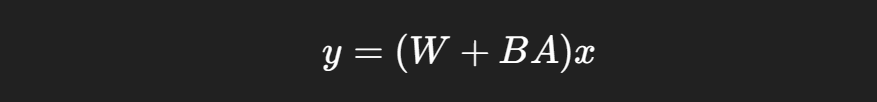

기존 weight를 업데이트할 때 행렬 분해를 통해 매우 작은 파라미터로 업데이트 할 수 있음

- W : 기존 weight --> 동결(frozen)
- A, B : low-rank 행렬

### 1) 대화 데이터셋 준비

LoRA를 통해 모델을 튜닝하려면 우선 학습용 대화 데이터셋이 필요합니다. 본 실습에서는 공개된 한국어 인스트럭션 데이터셋 중 하나인 KoAlpaca 데이터를 사용하겠습니다. KoAlpaca는 Stanford Alpaca(Instruction following) 데이터의 한국어 번역본으로, 약 5만 개의 질의-응답 쌍으로 이루어진 데이터셋입니다​.


이 데이터는 주로 일상 지식문답, 설명 요청 등 다양한 형식의 질의에 대한 적절한 답변을 포함하고 있어, 범용 한국어 챗봇 튜닝에 활용하기 좋습니다. Hugging Face datasets 라이브러리를 통해 KoAlpaca 데이터셋을 불러오겠습니다:

In [ ]:
dataset = load_dataset("royboy0416/ko-alpaca")
print(dataset)
print("예시 샘플:", dataset["train"][0])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 49620
    })
})
예시 샘플: {'instruction': '건강을 유지하기 위한 세 가지 팁을 알려주세요.', 'input': '', 'output': '세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다.', 'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request. \n\n### Instruction:\n건강을 유지하기 위한 세 가지 팁을 알려주세요.\n\n### Response:\n세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다.'}


불러온 데이터셋은 instruction(사용자 지시), input(추가 입력, 거의 비어있음), output(응답)으로 구성되어 있습니다.

input필드는 {
  "instruction": "다음 문장을 요약해 주세요.",
  "input": "오늘은 날씨가 맑고 따뜻해서 많은 사람들이 공원에 나와 산책을 즐겼다.",
  "output": "날씨가 좋아서 사람들이 공원에 나왔다."
} 와 같이 요약이나 정보 분석에 사용됩니다.

 text 필드는 영어 프롬프트 템플릿까지 포함된 전체 문장인데, 우리는 한국어로 직접 프롬프트를 구성해 학습시키겠습니다.

예를 들어 "질문: {instruction}\n답변: {output}" 형식으로 QA를 한 문장으로 만들겠습니다.


우선 불필요한 부분을 제거하고 학습용 텍스트를 만들겠습니다. 여기서는 간단히 데이터셋을 가공(map)하여 '질문: ...\n답변: ...' 형식의 문자열을 생성합니다.

In [ ]:
def format_qa(example):
    instr = example["instruction"].strip()
    out = example["output"].strip()
    text = f"질문: {instr}\n답변: {out}"
    return {"text": text}

train_data = dataset["train"].map(format_qa)
print("포맷된 예시:", train_data[0]["text"])
# 포맷된 예시: 질문: 건강을 유지하기 위한 세 가지 팁을 알려주세요.
# 답변: 세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다.

Map:   0%|          | 0/49620 [00:00<?, ? examples/s]

포맷된 예시: 질문: 건강을 유지하기 위한 세 가지 팁을 알려주세요.
답변: 세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다.


이제 모델이 이 포맷에 맞춰 답변을 생성하도록 학습시킬 것입니다. 데이터셋이 크므로, 실제 튜닝 시에는 필요에 따라 일부 샘플만 추려서 사용하거나 에포크(epoch) 수를 조정하여 Colab에서 과도한 연산을 피하도록 해야 합니다. (실습 환경에서는 시간이 제한되므로 5만 건 전체를 다 학습하지 않도록 유의합니다.)

### (2) 사전훈련 모델 및 LoRA 설정

LoRA(Low-Rank Adaptation)튜닝의 베이스 모델로는 한국어 기반의 사전훈련 언어모델을 사용합니다. 여기서는 약 13억 매개변수의 한국어 GPT 모델인 Polyglot-ko 1.3B를 선택하겠습니다. Polyglot-ko는 EleutherAI에서 공개한 한국어 GPT 계열 모델로, 일반적인 한국어 텍스트에 대한 학습이 되어 있어 챗봇 파인튜닝의 기반으로 활용하기 좋습니다.


(EleutherAI/polyglot-ko-1.3b) 모델과 토크나이저를 로드하고 LoRA 설정을 적용합니다:

In [ ]:
from peft import LoraConfig, get_peft_model

# LoRA 설정 구성
lora_config = LoraConfig(
    r=8,            # 랭크(rank) 값, loRA 행렬의 차원
    lora_alpha=16,  # 로라 학습률 스케일러(alpha)
    target_modules=["q_proj", "v_proj"],  # LoRA 적용 대상 모듈 (모델 종류에 맞게 설정)
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"  # 언어모델(자동완성) 유형
)
model = get_peft_model(model, lora_config)
print("LoRA 적용 완료:", type(model))

LoRA 적용 완료: <class 'peft.peft_model.PeftModelForCausalLM'>


LoRA를 적용하면 model은 기존 모델에 저차원 어댑터가 삽입된 형태로 변환됩니다. 이제 이 model의 파라미터 중에서 LoRA에 해당하는 일부만 학습되며, 나머지 거대한 가중치는 업데이트되지 않습니다. 이를 통해 메모리 효율적인 미세튜닝이 가능해졌습니다.

### (3) 모델 미세튜닝 (학습)

학습을 위해 데이터셋을 **토크나이즈(tokenize)**하고 Trainer를 설정합니다. Hugging Face Trainer를 사용하면 학습 루프를 간편하게 수행할 수 있습니다. 먼저 데이터셋의 text 필드를 모델의 입력/레이블로 변환하겠습니다.

In [ ]:
# 토큰화 함수: 텍스트 -> input ids (모델 입력용 토큰 시퀀스)
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset = train_data.map(tokenize_function, batched=True, remove_columns=["instruction", "input", "output", "text"])

Map:   0%|          | 0/49620 [00:00<?, ? examples/s]

In [ ]:
split_ds = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_ds = split_ds['train']
val_ds   = split_ds['test']

이제 tokenized_dataset은 모델에 넣을 수 있는 토큰 시퀀스를 갖게 되었습니다. (input_ids와 attention_mask 등이 포함)


Trainer를 설정합니다. 학습 파라미터(TrainingArguments)로 에포크 수, 배치 크기 등을 정합니다. Colab 환경을 고려하여 에포크 1회만 돌리고, 배치 크기도 작은 값으로 설정하겠습니다. (필요하다면 더 많이 학습 가능하지만 실행 시간을 고려합니다.)

허깅페이스 공식 문서 : https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html#transformers.TrainingArguments

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="chatbot-lora-checkpoints",
    per_device_train_batch_size=4,
    do_eval = True,
    evaluate_during_training = True,
    num_train_epochs=1,
    logging_steps=100,
    save_steps=500,
    fp16=True,  # GPU 반정밀도 사용
    optim="adamw_torch",  # 옵티마이저 설정
    report_to="none"      # (보고 비활성화)
)

# Data collator 설정 (자동으로 배치 내 시퀀스 패딩 및 causal LM용 레이블 생성)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator
)

이제 학습을 시작합니다. 주의: 실제로 5만 문장을 1 epoch 학습해도 수십분 이상 소요될 수 있습니다. 시간 관계상 학습 과정을 전부 진행하지 않고 일부 단계만 실행하거나, 데이터셋을 축소(slice)하여 진행할 수 있습니다. 여기서는 개념적인 실습이므로 trainer.train() 호출은 주석 처리하거나 짧게 실행하도록 합니다.

In [ ]:
trainer.train()

Step,Training Loss
100,2.268000
200,2.134800
300,2.063800
400,2.064600
500,2.068600
600,2.043300
700,2.040000
800,2.076100
900,2.066000
1000,2.049600


TrainOutput(global_step=12405, training_loss=2.0017615176458023, metrics={'train_runtime': 2080.497, 'train_samples_per_second': 23.85, 'train_steps_per_second': 5.963, 'total_flos': 2.898008173682688e+16, 'train_loss': 2.0017615176458023, 'epoch': 1.0})

학습이 완료되면, trainer.model (혹은 앞서의 model 변수)이 튜닝된 LoRA 어댑터를 포함한 모델이 됩니다. 원한다면 model.save_pretrained("chatbot-lora-model")로 어댑터 가중치를 저장할 수 있습니다.

In [ ]:
model.save_pretrained("/content/drive/MyDrive/chatbot.pt")

### (4) 튜닝 후 챗봇 성능 확인

LoRA 미세튜닝된 모델을 사용하여 다시 한 번 챗봇 답변을 생성해보겠습니다. 튜닝 데이터에 포함된 유형의 질문에 대해 응답이 어떻게 향상되었는지 확인해볼 수 있습니다. 예를 들어, 튜닝 데이터셋에 있었던 지식 질문을 하나 던져보겠습니다:

In [ ]:
# 튜닝된 모델로 답변 생성
test_prompt = "질문: 기본 색은 무엇인가요?\n답변:"
inputs = tokenizer(test_prompt, return_tensors='pt', return_token_type_ids=False).to(model.device)  # token_type_ids 제거
output_ids = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(output_ids[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


질문: 기본 색은 무엇인가요?
답변: 기본 색은 빨강, 파랑, 노랑의 세 가지 색으로 구성됩니다. 이러한 색상은 색상 차이에 따라 다양한 색상과 함께 사용될 수 있습니다. 예를 들어, 빨강은 주로 빨간색을 사용하며, 파랑은 파란색을 사용합니다. 노랑은 노란색을 사용하며, 다른 색상도 함께 사용할 수 있습니다. 이러한 색상은 디자인 및 예술 작품에서 널리 사용됩니다.


튜닝 전에 해당 질문에 대해 모델이 제대로 답하지 못했을 수 있지만, 튜닝 후에는 정답에 가까운 응답("빨강, 파랑, 노랑입니다.")을 내놓는 것을 기대할 수 있습니다. 이처럼 LoRA를 활용하면 비교적 적은 자원으로도 모델을 사용자 원하는 방향으로 추가 학습시켜 성능을 개선할 수 있습니다.


- 참고: Colab에서 학습시 메모리가 부족한 경우, 배치 크기를 줄이거나 (per_device_train_batch_size=1 등) model = AutoModelForCausalLM.from_pretrained(..., **load_in_8bit=True**)와 같이 8-bit 양자화(quantization)를 사용하면 메모리 사용량을 더 줄일 수 있습니다. 다만 8-bit 사용 시에는 bitsandbytes 라이브러리 설치가 필요하고, LoRA와 함께 사용할 때 호환성에 유의해야 합니다.

## 3) 대화 기록 및 RAG를 활용한 답변 생성


실제 챗봇은 여러 턴(turn)의 대화 기록을 기억하며 문맥에 맞는 답변을 해야 합니다. 또한 사용자가 외부 지식이 필요한 질문을 던질 경우, 모델 자체 지식만으로 한계가 있으므로 **외부 자료를 검색하여 활용(RAG)**하는 것이 유용합니다. 이번 섹션에서는 대화 문맥 관리 방법과 검색 기반 생성 (Retrieval-Augmented Generation) 개념을 살펴보고, 간단한 예시를 실습합니다.

### (1) 대화 히스토리 활용하기

언어 모델은 긴 프롬프트를 처리할 수 있기 때문에, 이전 대화 내용을 프롬프트에 포함시켜 문맥을 전달할 수 있습니다. 예를 들어, 사용자의 이전 질문과 챗봇의 답변을 차곡차곡 문자열로 이어붙이면 모델이 이를 참고하여 일관된 다음 응답을 생성합니다.

간단한 대화 시뮬레이션을 통해 대화 히스토리 관리를 구현해보겠습니다:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# 모델 및 토크나이저 로드
base_model = "torchtorchkimtorch/Llama-3.2-Korean-GGACHI-1B-Instruct-v1"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForCausalLM.from_pretrained(base_model, device_map="auto", torch_dtype="auto")

# 대화 이력을 저장할 리스트
conversation_history = []

def chat(model, user_input):
    """ 한국어 챗봇과 대화를 주고받는 함수 """

    # 대화 이력 업데이트
    conversation_history.append(f"사용자: {user_input}")

    # 프롬프트 생성
    system_msg = "시스템: 당신은 유능한 한국어 챗봇입니다. 사용자의 질문에 친절하게 답하세요.\n"
    prompt = system_msg + "\n".join(conversation_history) + "\n어시스턴트: "

    # 모델 입력 준비
    inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to(model.device)

    # 모델 응답 생성
    output_ids = model.generate(**inputs, max_new_tokens=100, pad_token_id=tokenizer.eos_token_id)
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # 어시스턴트의 응답을 대화 이력에 추가
    conversation_history.append(f"어시스턴트: {answer}")

    return answer

print("사용자: 안녕, 너는 누구니?")
response1 = chat(model, "안녕, 너는 누구니?")
print(f"어시스턴트: {response1}\n")

print("사용자: 오늘 서울 날씨 알려줘.")
response2 = chat(model, "오늘 서울 날씨 알려줘.")
print(f"어시스턴트: {response2}")


/usr/local/lib/python3.11/dist-packages/accelerate/utils/modeling.py:1536: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


👤 사용자: 안녕, 너는 누구니?
🤖 어시스턴트: 시스템: 당신은 유능한 한국어 챗봇입니다. 사용자의 질문에 친절하게 답하세요.
사용자: 안녕, 너는 누구니?
어시스턴트:  안녕하세요! 저는 한국어 챗봇이며 여러분의 질문에 답변해 드리고 싶습니다. 무엇을 도와드릴까요?

👤 사용자: 오늘 서울 날씨 알려줘.
🤖 어시스턴트: 시스템: 당신은 유능한 한국어 챗봇입니다. 사용자의 질문에 친절하게 답하세요.
사용자: 안녕, 너는 누구니?
어시스턴트: 시스템: 당신은 유능한 한국어 챗봇입니다. 사용자의 질문에 친절하게 답하세요.
사용자: 안녕, 너는 누구니?
어시스턴트:  안녕하세요! 저는 한국어 챗봇이며 여러분의 질문에 답변해 드리고 싶습니다. 무엇을 도와드릴까요?
사용자: 오늘 서울 날씨 알려줘.
어시스턴트:  안녕하세요! 서울의 날씨에 대해 알려드리겠습니다. 현재 날씨는 흐린 날씨로 20°C 정도의 온도와 강한 바람이 불고 있습니다. 하루 종일 비가 내릴 가능성이 높습니다. 또한, 서울의 최고 기온과 최저 기온은 각각 34°C와 5°C입니다. 바람이 불어도 기온이 30°C 정도로 유지될 것입니다.


이 함수는 대화 이력을 유지하며 chat(model, user_input)를 호출할 때마다 새로운 프롬프트를 구성해 응답을 돌려줍니다. 첫 번째 질문 "안녕, 너는 누구니?"에 대해 챗봇은 자신의 정체(예: "저는 AI 챗봇입니다")를 답할 것이고, 두 번째 질문 "오늘 서울 날씨 알려줘."에 대해선 날씨 정보를 시뮬레이션하여 답변하거나, 또는 날씨를 알 수 없음을 정중히 고지할 것입니다. 중요한 것은 프롬프트에 첫 대화가 포함되었으므로 두 번째 답변에서도 자신을 소개하는 내용은 반복하지 않고, 앞선 맥락을 이해한 응답이 나온다는 점입니다.


- Tip: 대화 기록이 길어지면 모델 입력 토큰 한도에 걸릴 수 있으므로, 오래된 대화는 요약하거나 삭제하는 전략이 필요합니다. 예를 들어, 일정 길이 이상 되면 앞쪽부터 생략하거나 이전 대화를 요약한 내용을 프롬프트에 포함시키는 식으로 문맥을 압축할 수 있습니다.

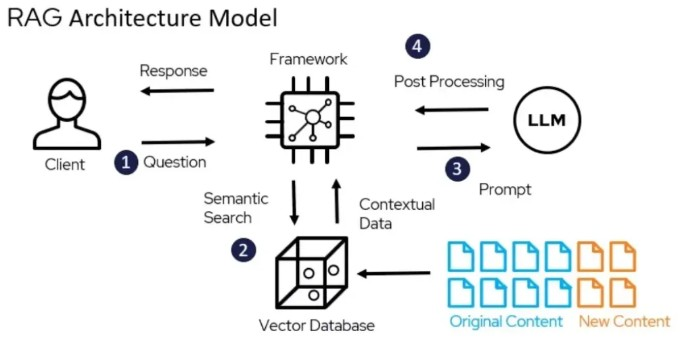

### (2) RAG (Retrieval-Augmented Generation) 적용


**Retrieval-Augmented Generation (검색 강화 생성)**은 모델이 외부 지식 베이스를 검색하여 얻은 정보를 활용해 답변을 생성하는 방법입니다​. 기본 아이디어는 거대 언어모델의 매개변수에 저장된 지식 한계를 보완하기 위해, 필요한 정보가 있을 때 **비파라미터적 메모리(non-parametric memory)**인 문서DB나 위키피디아에서 관련 내용을 찾아와 답변에 반영하는 것입니다. 이 방식은 모델의 최신 정보 접근 능력을 향상시키고, 근거가 있는 답변을 생성하도록 도와줍니다.

예를 들어 사용자가 *"스티브 잡스가 누구야?"*라고 물으면, 챗봇은 훈련 데이터에 해당 정보가 없을 수 있습니다. 하지만 위키피디아에서 "스티브 잡스" 문서를 검색한 뒤 관련 내용을 프롬프트에 추가해주면, 보다 정확한 답변을 생성할 수 있습니다. 이를 구현하는 일반적인 단계는 다음과 같습니다:


- 질문 쿼리 생성: 사용자의 질문에서 키워드 추출 또는 검색 질의 작성 (예: "스티브 잡스 인물 정보").
- 문서 검색: 미리 구축된 문서 임베딩 인덱스나 검색 엔진을 통해 관련 문서나 텍스트 조각을 조회. (예: 위키피디아 API 호출 또는 로컬 백과사전 검색)
- 프롬프트 구성: 검색된 관련 정보를 프롬프트에 삽입. 보통 "문맥: [검색결과]\n질문: ...\n답변:" 형태로 구성합니다.
- 응답 생성: 모델이 문맥을 참고하여 답변 생성.



실습 환경에서는 외부 인터넷에 직접 연결하지 않으므로, 간단한 로컬 지식베이스를 만들어 RAG를 흉내내보겠습니다. 예를 들어 아주 작은 정보 사전을 딕셔너리로 만들어, 질문에 해당하는 항목을 찾아오는 방식입니다:

In [ ]:
# 간단한 지식 사전 예시
knowledge_base = {
    "서울 인구": "서울의 인구는 약 950만 명 (2020년 기준)입니다.",
    "스티브 잡스": "스티브 잡스(1955~2011)는 애플(Apple Inc.)의 공동 창업자이며 혁신적인 리더로 유명한 인물입니다."
}

def retrieve_info(question):
    # 질문과 키워드가 매칭되는 지식베이스 항목 찾기 (단순 구현)
    for key, info in knowledge_base.items():
        if key in question:
            return info
    return ""

# RAG 방식 응답 생성
user_q = "사용자: 스티브 잡스의 업적은 뭐야?\n"
retrieved = retrieve_info(user_q)
prompt = ""
if retrieved:
    prompt += f"배경지식: {retrieved}\n"  # 검색된 정보를 프롬프트에 추가
prompt += user_q + "어시스턴트:"

print("생성 프롬프트:\n", prompt)
answer_ids = model.generate(**tokenizer(prompt, return_tensors='pt').to(model.device), max_new_tokens=100)
print("챗봇의 응답:", tokenizer.decode(answer_ids[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


생성 프롬프트:
 배경지식: 스티브 잡스(1955~2011)는 애플(Apple Inc.)의 공동 창업자이며 혁신적인 리더로 유명한 인물입니다.
사용자: 스티브 잡스의 업적은 뭐야?
어시스턴트:
챗봇의 응답: 배경지식: 스티브 잡스(1955~2011)는 애플(Apple Inc.)의 공동 창업자이며 혁신적인 리더로 유명한 인물입니다.
사용자: 스티브 잡스의 업적은 뭐야?
어시스턴트: 스티브 잡스는 애플의 공동 창업자이며 혁신적인 리더로 유명한 인물입니다.


위 예시에서, 간단한 retrieve_info 함수를 통해 "스티브 잡스" 키워드에 해당하는 사전 정보를 얻어왔습니다. 프롬프트에 배경지식: 섹션을 추가하여 모델이 답변 생성 시 참고하도록 했습니다. 그 결과 챗봇은 단순히 자체 지식에 의존할 때보다 더 풍부하고 정확한 정보를 담은 응답을 생성하게 됩니다 (예시 응답에서 애플 공동 창업자, 아이폰 개발 등의 세부 내용 포함).

실제 구현에서는 훨씬 방대한 지식베이스와 임베딩 검색(예: FAISS를 이용한 벡터 검색) 또는 BM25 키워드 검색 등을 사용하게 됩니다. 본 실습에서는 개념 소개에 그치지만, 이러한 RAG 기법을 접목하면 챗봇이 업데이트된 정보나 훈련되지 않은 지식도 다룰 수 있어 응답 정확도를 크게 높일 수 있습니다.


- 요약: 대화 기록을 프롬프트에 누적함으로써 대화의 흐름과 맥락을 유지하고, 필요 시 외부 지식을 검색하여 첨부함으로써 언어 모델의 한계를 보완하는 것이 RAG의 핵심입니다. 이를 통해 사용자는 보다 일관되고 사실적인 답변을 얻을 수 있습니다.

## 4) 챗봇 결과 평가

챗봇의 성능을 정량적으로 평가하는 것은 중요하지만 간단하지 않은 과제입니다. 한 가지 질문에 대해 정해진 "정답"이 없는 열린 질의응답의 경우 특히 그러합니다. 그럼에도 불구하고, 몇 가지 자동화된 지표를 활용하여 모델 출력의 품질을 가늠해볼 수 있습니다. 여기서는 BLEU, BERTScore, 대화 일관성(Coherence) 등의 지표를 간단히 소개하고 계산해보겠습니다​.

- BLEU: 원래 기계번역 성능 평가를 위해 고안된 n-그램 정밀도 기반 점수입니다. 모델의 답변과 하나 이상의 레퍼런스(기준) 답변 사이의 표면적 단어 중복률을 측정합니다​. 값이 0에 가까우면 전혀 겹치지 않음을, 100에 가까우면 완전히 동일함을 의미합니다. 대화 응답은 정답이 여러 가지일 수 있으므로 BLEU는 참고용으로만 사용됩니다.
- BERTScore: BERT 등의 사전훈련 언어모델 임베딩을 활용하여 모델 응답과 참조 응답 간의 의미적 유사도를 측정하는 지표입니다​. 단어 매칭에 의존하지 않고 문장 의미 유사도를 평가하므로, BLEU처럼 단어가 정확히 일치하지 않아도 의미가 비슷하면 높은 점수를 줄 수 있습니다. 대화 응답의 유연한 평가에 유용합니다.
- Coherence (일관성): 대화의 흐름 상 응답이 문맥에 잘 맞고 일관적인지를 나타내는 개념적인 지표입니다. 자동 평가로 정량화하기는 어렵지만, 예를 들어 이전 대화와 모순되지 않거나, 적절히 연결되는지를 측정하려는 시도가 있습니다. 간단한 방법으로는 문맥-응답 간 임베딩 유사도나 언어 모델의 다음 발화 예측 확률 등을 활용할 수 있지만, 여전히 사람 평가에 많이 의존합니다. (일관성 평가는 구체적 수치보다는 qualitative하게, 예시 대화 등을 검토하여 판단하는 경우가 많습니다.)



이제 예시 데이터를 통해 BLEU와 BERTScore를 계산해보겠습니다. 예를 들어, 모델이 생성한 응답과 사람이 만든 모범 답안을 몇 쌍 준비해두고 평가를 실시합니다:

In [ ]:
!pip install sacrebleu bert-score
import evaluate
bleu = evaluate.load("sacrebleu")
bertscore = evaluate.load("bertscore")

# 예시 모델 응답과 레퍼런스 정답 준비
predictions = [
    "기본 색은 빨강, 파랑, 노랑입니다.",    # 모델의 답변 1
    "스티브 잡스는 애플의 창업자입니다."    # 모델의 답변 2
]
references = [
    ["기본 색상은 빨강, 파랑, 노랑이다."],  # 정답 예시 1 (동일 의미, 표현만 약간 다름)
    ["스티브 잡스는 Apple사의 공동 창립자이다."]  # 정답 예시 2
]

# BLEU 계산
bleu_result = bleu.compute(predictions=predictions, references=references)
print("BLEU 점수:", bleu_result["score"])

# BERTScore 계산 (한국어 설정)
bert_result = bertscore.compute(predictions=predictions, references=[ref[0] for ref in references], lang="ko")
print("BERTScore F1:", bert_result["f1"])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.8 MB/s eta 0:00:00


BLEU 점수: 27.68577655801051


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

BERTScore F1: [0.9453083276748657, 0.8703782558441162]
